In [1]:
import numpy as np 
import pandas as pd
import allel
import malariagen_data
%matplotlib inline
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
%run hapclust.py


In [2]:
def plot_snps(transcript, data, cohorts, width=1500, height=600, palette='Category10', sample_set="sample_set"):

    # hover tooltips
    tooltips = [
        ("position", '@contig:@position{,}'),
        ("alleles", '@ref_allele>@alt_allele'),
        ("pass", "@pass_gamb_colu_arab, @pass_gamb_colu, @pass_arab"),
        ("impact", '@impact'),
        ("effect", '@effect'),
        ("aa_change", '@aa_change'),
        ("frequency", '@frequency{%f} (@cohort)'),
        ("freqdiff from wildtype", '@freq_diff_from_wt{%f}'),
    ]

    fig1 = bokeh.plotting.figure(
        title=f'Transcript - {transcript}',
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        plot_width=width, 
        plot_height=height, 
        tooltips=tooltips,
        toolbar_location="above")

    # set up colors
    palette = bokeh.palettes.all_palettes[palette]
    colors = palette[len(cohorts)] if len(cohorts) > 2 else palette[3]
    
    # plot allele frequencies
    for coh, color in zip(cohorts, colors):
        df = data.copy()
        # add X coordinate in Mbp
        df['x'] = df['position'] / 1e6
        df['frequency'] = df[coh]
        df['cohort'] = coh
        df['freq_diff_from_wt'] = data[f"{coh} | freqdiff"] if "wt" not in coh else 0 
        diffdf = df.query("freq_diff_from_wt > 0.4")
        df = df.query("freq_diff_from_wt < 0.4")
        fig1.triangle("x", coh, 
                      size=8, 
                      color=color,
                      source=df,
                      legend_label=coh)
        fig1.circle("x", coh, 
                    size=10, color=color, 
                    source=diffdf,
                    legend_label=coh)

    # tidy up the plot
    fig1.y_range = bokeh.models.Range1d(-0.05, 1.1)
    fig1.yaxis.axis_label = f'Alt allele frequency'
    fig1.xaxis.visible = False
    fig1.add_layout(fig1.legend[0], 'right')
    fig1.legend.click_policy="hide"

    # plot transcript
    fig2 = plot_transcript(transcript, width=width, height=80, show=False, 
                           x_range=fig1.x_range)
    fig2.toolbar.logo = None 
    fig2.toolbar_location = None
    fig2.title = None #sample_set

    bokeh.plotting.show(bokeh.layouts.column(fig1, fig2))
    
def plot_transcript(transcript, width=700, height=120, show=True, x_range=None,
                    toolbar_location='above'):

    # find the gene
    df_geneset = ag3.geneset().set_index("ID")
    parent  = df_geneset.loc[transcript]

    # define tooltips for hover
    tooltips = [
        ("Type", '@type'),
        ("Location", '@contig:@start{,}..@end{,}'),
    ]

    # make a figure
    fig = bokeh.plotting.figure(
        title=f'Transcript - {transcript} ({parent.strand})',
        plot_width=width, 
        plot_height=height,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        toolbar_location=toolbar_location,
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
        x_range=x_range,
    )

    # find child components of the transcript
    data = df_geneset.query(f"Parent == '{transcript}'").copy()
    data['left'] = data['start'] / 1e6  # plot in Mbp coordinates
    data['right'] = data['end'] / 1e6  # plot in Mbp coordinates
    data['bottom'] = -0.4
    data['top'] = 0.4

    # plot exons
    exons = data.query("type == 'exon'")
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=exons, fill_color=None, line_color='black', line_width=.5, 
             fill_alpha=0)
    
    # plot introns
    for l, r in zip(exons[:-1]['right'], exons[1:]['left']):
        m = (l + r) / 2
        fig.line([l, m, r], [0, .1, 0], line_width=1, line_color="black")

    # plot UTRs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'five_prime_UTR'"), 
                fill_color='green', line_width=0, fill_alpha=.5)
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'three_prime_UTR'"), 
                fill_color='red', line_width=0, fill_alpha=.5)

    # plot CDSs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data.query("type == 'CDS'"), 
             fill_color='blue', line_width=0, fill_alpha=.5)

    fig.yaxis.ticker = []
    fig.xaxis.axis_label = f'Position (Mbp)'
    fig.y_range = bokeh.models.Range1d(-.6, .6)

    fig.xaxis.axis_label = f'Contig {parent.contig} position (Mbp)'

    # show the figure
    if show:
        bokeh.plotting.show(fig)

    return fig

def clustersToFrequencies(transcript, cluster_spans, geno, pos, SNPeffect='NON_SYNONYMOUS_CODING', max_af=0.02, min_cohort_size=5, sample_set="sample_set"):
    
    # get totals in each sweep for swept and wt, store in dict
    cohorts = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > min_cohort_size}
    wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cohort_size}
    lenwt = len(np.concatenate(list(wt.values())))
    cohorts[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))
    
    probe.log(f"There are {len(cohorts.keys())} clusters with {[len(c) for c in cohorts.values()]}")
    
    #calculate allele freqs in cohort 
    df_snps = get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size)
    # filter to snp eff and max af
    df_snps_filtered = df_snps.query("effect == @SNPeffect and max_af > @max_af")
    
    #change cohort dict keys to amino acid signature (what is diff from wt?)
    newcohort, df_snps_filtered = get_aasig_for_swept_cohorts(cohorts, df_snps_filtered)
    
    #plot allele frequencies for each cohort 
    #plot_snps(transcript, data=df_snps_filtered, cohorts=newcohort, sample_set=sample_set)
    
    return(df_snps_filtered, newcohort)

def TranscriptSweptAlleleFreqs(snps, pos, transcript, cut_height = 120, t=2, min_cohort_size=5, sample_set="sample_set", dendro_only=False, metaquery=None):
    
    probe.log("Remapping haplotype alleles to match snp effect data...")   
    haplos = allel.GenotypeArray(snps['call_genotype']).to_haplotypes()
    haplos, pos = remap_haplo_alleles(haplos=haplos, haplo_pos=pos, transcript=transcript, metaquery=metaquery)
        
    probe.log("Clustering genotypes")
    fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haplos, 
                                                              truncate_distance=t,
                                                              cut_height=cut_height,
                                                              dpi=150, label_clusters=False)
    plt.show()
    
    probe.log("Finding allele frequencies from cluster indices")
    # Take clusters and get freqs in each cluster
    df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=haplos, pos=pos, min_cohort_size=min_cohort_size, sample_set=sample_set)

    return(df_snps_filtered, newcohort, leaves)
    
    
def phase3cluster(sample_set, transcript, contig, metaquery=None, cut=2, t=2, min_cohort_size=5):
    snps = ag3.haplotypes(transcript, sample_sets=sample_set, analysis='gamb_colu')
    meta = ag3.sample_metadata(sample_set)

    if metaquery != None:
        meta = ag3.sample_metadata(cohorts)
        meta = meta.query(metaquery)
        sample_bool = np.isin(snps['sample_id'].compute(), meta['sample_id'])
        snps = snps.isel(samples=sample_bool)

    probe.log(f"{sample_set}, query={metaquery}, cohort_size : {snps['call_genotype'].shape[1]}")

    df_af, coh, leaves = TranscriptSweptAlleleFreqs(snps, allel.SortedIndex(snps['variant_position']), transcript, cut_height=cut, t=t, min_cohort_size=min_cohort_size, sample_set=sample_set, metaquery=metaquery)  
    return(df_af, coh, leaves)

def get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size):
    freq_cols = dict()
    for coh, loc_coh in cohorts.items():
        n_samples = np.count_nonzero(loc_coh)
        if n_samples == 0:
            raise ValueError(f"no samples for cohort {coh!r}")
        if n_samples >= min_cohort_size:
            gt_coh = geno.take(loc_coh, axis=1)
            # count alleles
            ac_coh = gt_coh.count_alleles(max_allele=3)
            # compute allele frequencies
            af_coh = ac_coh.to_frequencies()
            # add column to dict
            freq_cols[coh] = af_coh[:, 1:].flatten()

    # build a dataframe with the frequency columns
    df_freqs = pd.DataFrame(freq_cols)

    # compute effects for all SNPs in chosen transcript
    df_effects = ag3.snp_effects(
        transcript=transcript, 
    )
    
    pos_bool = np.isin(df_effects['position'], pos)
    df_effects = df_effects[pos_bool]
    
    # build the final dataframe
    df_effects.reset_index(drop=True, inplace=True)
    df_snps = pd.concat([df_effects, df_freqs], axis=1)

    # add max allele freq column (concat here also reduces fragmentation)
    df_snps = pd.concat(
        [
            df_snps,
            pd.DataFrame(
                {"max_af": df_snps[list(freq_cols.keys())].max(axis=1)}
            ),
        ],
        axis=1,
    )
    return(df_snps)


def get_aasig_for_swept_cohorts(cohorts, df_snps_filtered):
    newcohort = {}
    for key, idxs in cohorts.items():
        # copy df
        df = df_snps_filtered.copy()
        # calculate AF diff between wt and each sweep
        df['af_diff']= df[key] - df.filter(regex="wt").iloc[:,0]
        # difference has to be greater than 0.4 (arbitrary)
        aadiff = df[df['af_diff'] > 0.4]['aa_change'] #.abs() used if we want aa reversion to show on signature
        # remove first digits
        aa = aadiff.str.slice(1)
        aa = ",".join(aadiff)
        n = int(''.join(filter(str.isdigit, key)))
        aa = f"n={n} | {aa}"
        if "wt" not in key:
            newcohort[aa] = idxs
            df_snps_filtered = df_snps_filtered.rename(columns={key:aa})
            df_snps_filtered[f"{aa} | freqdiff"] = (df_snps_filtered.filter(regex="wt").iloc[:,0] - df_snps_filtered[aa]).abs()
        else:
            newcohort[key] = idxs
        
    return(newcohort, df_snps_filtered)

def remap_haplo_alleles(haplos, haplo_pos, transcript, metaquery):
    """
    Because haplotypes are coded 0,1, but genotypes 0-3, 1s in the haplotype may refer to different ALTs in the genotype array. This
    causes a problem when using ag3.snp_effects() to fit alleles to their aa change, therefore, we need to recode alleles back to the correct
    ALT
    """
    # Load genotype data - needed to find correct ALT for each SNP
    geno = allel.GenotypeDaskArray(ag3.snp_genotypes(region=transcript, sample_sets=cohorts))
    meta = ag3.sample_metadata(cohorts)
    if metaquery != None:
        meta = meta.query(metaquery)
    geno = geno.take(meta.index.to_list(), axis=1)
    geno_pos = allel.SortedIndex(ag3.snp_sites(region=transcript, field='POS').compute())
    
    # find intersection between haplotype positions and genotypes 
    geno_mask, hap_mask = geno_pos.locate_intersection(haplo_pos)
    geno = geno.compress(geno_mask, axis=0)
    ac = geno.count_alleles().compute()
    
    # remove multiallelics, there shouldnt be any in here?
    multiallele_mask = (ac > 0).sum(axis=1) > 2
    ac = ac[~multiallele_mask]
    # find appropriate allele
    mappings = np.argmax(ac[:,1:], axis=1) + 1
    # make mapping array for scikit-allel
    zeros = np.zeros(len(mappings))
    mapping = np.vstack([zeros, mappings]).T
    
    # Remap!
    haplos = haplos[~multiallele_mask].map_alleles(mapping)
    haplo_pos  = haplo_pos[~multiallele_mask]
       
    return(haplos, haplo_pos)

## COE sweeps analysis

In [3]:
ag3 = malariagen_data.Ag3(pre=True)

In [4]:
cohorts = [
    # Ag1000G phase 3 Ghana sample set in Ag3.0
    "AG1000G-GH",
    # Amenta-Etego sample sets in Ag3.3
    #'1190-VO-GH-AMENGA-ETEGO-VMF00013',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00014',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00028',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00029',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00046',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00047',
    # GAARDIAN sample set in Ag3.4
    #'1244-VO-GH-YAWSON-VMF00149',
    'AG1000G-ML-A',
    'AG1000G-BF-A',
    'AG1000G-BF-B',
    'AG1000G-GN-A',
    'AG1000G-GN-B',
    # GAARD Ghana sample set in Ag3.2
    "1244-VO-GH-YAWSON-VMF00051",
    '1245-VO-CI-CONSTANT-VMF00054',
    '1253-VO-TG-DJOGBENOU-VMF00052',
    '1237-VO-BJ-DJOGBENOU-VMF00050'
]

In [5]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

def load_metahaps(cohorts, names, metaquery = "aim_species == 'gambiae'"):
    meta = ag3.sample_metadata(cohorts)
    meta = meta.query("sample_id in @names")
    meta.loc[:, 'sample_id'] = pd.Categorical(meta['sample_id'], categories = names, ordered = True)
    if metaquery != None: 
        query_bool = meta.eval(metaquery)
        meta = meta.query(metaquery)
    meta = meta.sort_values(by='sample_id')
    metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
    metahaps.columns = meta.columns
    return(metahaps, query_bool)

def check_order(meta, order, col='sample_id'):
    assert meta[col].to_list() == order, "Order of metadata is incorrect"
    print("correct order")
    
def haplotypes_to_aa_pandas(haps_xarray, snpdf, myquery="max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'", reverse=False, metaquery= "aim_species == 'gambiae'"):
    #Subset the data to all aa changes above 5% frequency
    aa_snps = snpdf.query(myquery)['position'].to_list()
    pos_bool = allel.SortedIndex(haps_xarray['variant_position'].values).locate_intersection(aa_snps)[0]
    print(f"There are {len(aa_snps)} amino acid changes with {myquery}")
    
    metahaps, query_bool = load_metahaps(cohorts, names, metaquery=metaquery)
    haps2 = allel.GenotypeArray(haps_xarray['call_genotype'].isel(variants=pos_bool, samples=query_bool).compute()).to_haplotypes()
    
    haps_df = pd.DataFrame(haps2)
    haps_df.loc[:, 'aa_change'] = snpdf.query(myquery).reset_index()['aa_change']
    haps_df = haps_df.set_index('aa_change')
    haps_df = haps_df.iloc[::-1] if reverse == True else haps_df # only if reverse strand like AGAP006227
    return(haps_df) # can only run once!

### Load cohorts

Which populations do we want to look at?

In [6]:
contig= '2L'

coeae1f_start = 28_545_396
coeae1f_end = 28_547_938
coeae2f_start = 28_548_433
coeae2f_end = 28_550_748

coeregion = '2L:28520000-28580000'

transcript= "AGAP006227-RA"
gene = transcript.replace("-RA", "")

#### Get aa presence/absence for each haplotype

['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=aim_species == 'gambiae', cohort_size : 1015
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


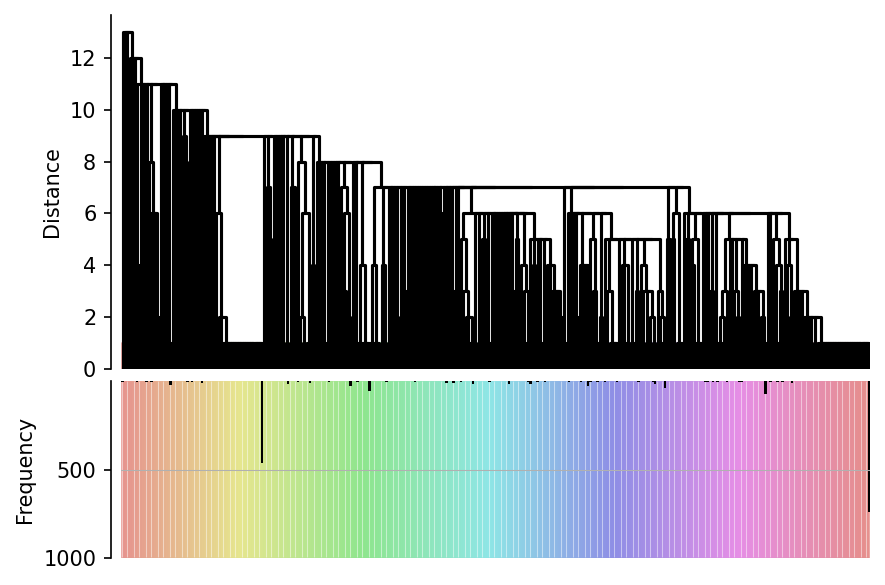

Finding allele frequencies from cluster indices
There are 5 clusters with [462, 58, 75, 739, 696]
['AG1000G-GH', 'AG1000G-ML-A', 'AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GN-B', '1244-VO-GH-YAWSON-VMF00051', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=aim_species == 'gambiae', cohort_size : 1015
Remapping haplotype alleles to match snp effect data...
Clustering genotypes


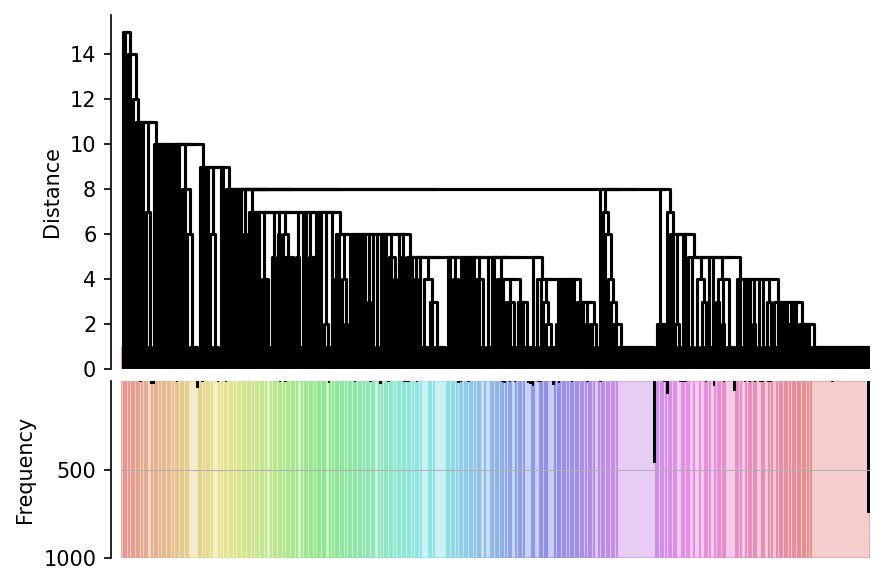

Finding allele frequencies from cluster indices
There are 5 clusters with [478, 76, 59, 776, 601]


In [58]:
snpdf_227, coho, leav = phase3cluster(cohorts, "AGAP006227-RA", contig, cut=1, t=0, min_cohort_size=40, metaquery="aim_species == 'gambiae'")
snpdf_228, coho2, leav = phase3cluster(cohorts, "AGAP006228-RA", contig, cut=1, t=0, min_cohort_size=40, metaquery="aim_species == 'gambiae'")

### Load metadata and haplotypes

In [8]:
metaquery = "aim_species == 'gambiae'"

snps = ag3.haplotypes(contig, sample_sets=cohorts, analysis='gamb_colu')
names = snps['sample_id'].values
pos = allel.SortedIndex(snps['variant_position'])
gene_bool = pos.locate_ranges([coeae1f_start], [coeae2f_end])
metahaps, query_bool = load_metahaps(cohorts, names, metaquery=metaquery)
haps = allel.GenotypeArray(snps['call_genotype'].isel(variants=gene_bool, samples=query_bool).compute()).to_haplotypes()

assert metahaps.shape[0] == haps.shape[1], "Wrong shape Dude!!"

print(haps.shape)
print(metahaps.shape)

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


(2010, 2030)
(2030, 26)


AssertionError: Wrong shape!!

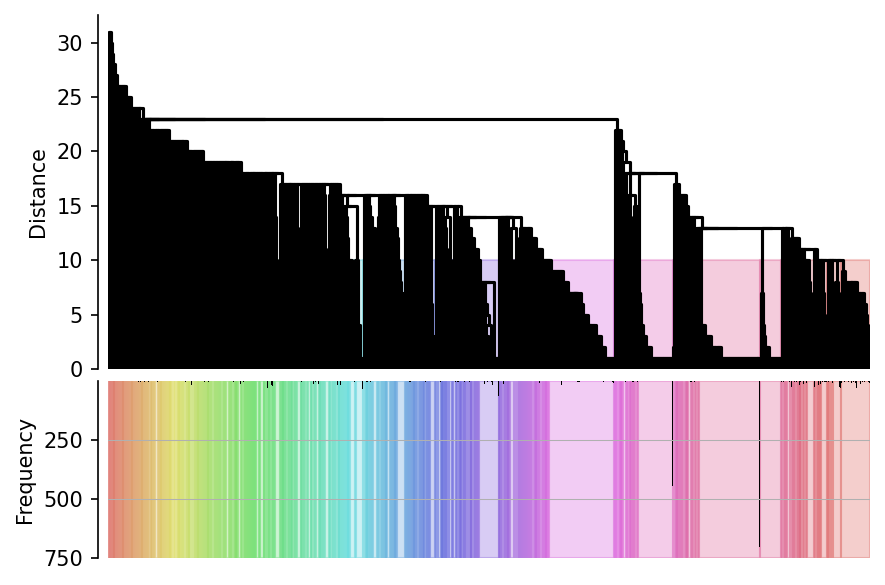

In [66]:
fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haps, 
                                                          truncate_distance=0,
                                                          cut_height=10,
                                                          dpi=150, label_clusters=False)

leaf_order = flatten_list(leaves)
assert len(leaf_order) == metahaps.shape[0], "Wrong shape!!"

In [69]:
coho = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > 30}
wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < 30}
lenwt = len(np.concatenate(list(wt.values())))
coho[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))

In [70]:
coho.keys()

dict_keys(['Sweep n=53', 'Sweep n=122', 'Sweep n=120', 'Sweep n=486', 'Sweep n=775', 'Sweep n=383', 'Sweep n=76', 'Sweep n=64', 'Sweep n=127', 'wt n=1050'])

In [11]:
hap_labels = list(coho.keys()) 

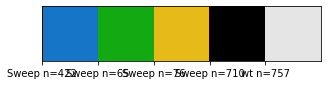

In [12]:
palette = sns.color_palette('nipy_spectral', n_colors=len(hap_labels) - 2, desat=0.8)
# add a colour for other_resistant
palette.append((0, 0, 0))
# add a colour for wt 
palette.append((0.9, 0.9, 0.9))
# check
sns.palplot(palette)
plt.gca().set_xticklabels(hap_labels);

Freq per location

In [13]:
metahaps, q = load_metahaps(cohorts, names)

for k, v in coho.items():
    
    metahaps.loc[v, 'HapCluster'] = k
    
    sweep_names = metahaps.take(v)
    
    
    g = sweep_names.groupby('sample_id')
    sweep_names.loc[:, 'sample_id'] += g.cumcount().astype(str).replace("0", "").mask(g['sample_id'].transform('count')==1,'')

meta_sweeps = metahaps.pivot_table(index='HapCluster', columns=['country', 'location', 'latitude', 'longitude'], aggfunc='count', fill_value=0).T.droplevel(level=0)
meta_sweeps

HapCluster                                       Sweep n=422  Sweep n=65  \
country       location       latitude longitude                            
Burkina Faso  Bana Village   11.233   -4.472              36           0   
              Pala           11.151   -4.235              55           0   
              Souroukoudinga 11.238   -4.235              42           0   
Cote d'Ivoire Aboisso        5.467    -3.200               8           4   
Ghana         Koforidua      6.094    -0.261               2           5   
...                                                      ...         ...   
Mali          Ouassorola     12.900   -8.160               3           0   
              Takan          11.470   -8.330               1           0   
              Tieneguebougou 12.810   -8.080               0           0   
              Toumani Oulena 10.830   -7.810              35           0   
Togo          Baguida        6.161     1.314               7          19   

HapCluster                                       Sweep n=710  Sweep n=76  \
country       location       latitude longitude                            
Burkina Faso  Bana Village   11.233   -4.472               7           0   
              Pala           11.151   -4.235              10           0   
              Souroukoudinga 11.238   -4.235               6           0   
Cote d'Ivoire Aboisso        5.467    -3.200              47           1   
Ghana         Koforidua      6.094    -0.261               9           0   
...                                                      ...         ...   
Mali          Ouassorola     12.900   -8.160               1           2   
              Takan          11.470   -8.330               1           0   
              Tieneguebougou 12.810   -8.080               0           0   
              Toumani Oulena 10.830   -7.810              10           0   
Togo          Baguida        6.161     1.314             157          37   

HapCluster                                       wt n=757  
country       location       latitude longitude            
Burkina Faso  Bana Village   11.233   -4.472           31  
              Pala           11.151   -4.235           63  
              Souroukoudinga 11.238   -4.235           38  
Cote d'Ivoire Aboisso        5.467    -3.200           14  
Ghana         Koforidua      6.094    -0.261           30  
...                                                   ...  
Mali          Ouassorola     12.900   -8.160            2  
              Takan          11.470   -8.330            8  
              Tieneguebougou 12.810   -8.080            2  
              Toumani Oulena 10.830   -7.810           75  
Togo          Baguida        6.161     1.314          138  

[352 rows x 5 columns]

In [14]:
totals = meta_sweeps.sum(axis=1).to_numpy()
meta_freqs = meta_sweeps.apply(lambda x: x/totals)
meta_freqs.loc[:, 'n'] = totals
#meta_freqs.to_csv("../../results/coe_sweep_frequencies.tsv", sep="\t")

Lets load the haplotype data, and load the haplotype metadata. Its important to check the order of the metadata matches the haplotypes at each stage, particularly as we re-order the haplotype metadata based on the heirarchical clustering.

In [15]:
id_order = metahaps['sample_id'].to_list()
id_order_clustered = metahaps.iloc[leaf_order, :]['sample_id'].to_list()
check_order(metahaps, id_order)

correct order


Extract a pandas dataframe of the haplotypes at the amino acid positions of interest

In [16]:
haps_df_227 = haplotypes_to_aa_pandas(snps, snpdf_227, myquery="max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'", reverse=True)
haps_df_227 = haps_df_227.iloc[:, leaf_order]
haps_df_228 = haplotypes_to_aa_pandas(snps, snpdf_228, myquery="max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'", reverse=False)
haps_df_228 = haps_df_228.iloc[:, leaf_order]

There are 11 amino acid changes with max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'


/home/sanj/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


There are 7 amino acid changes with max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'


Extract the order of the cohorts, and load karyotype data and merge with metadata, for plotting.

In [17]:
pop_column = 'country'
pop_order = metahaps.iloc[leaf_order, :][pop_column]
pop_order = pop_order.to_frame()
pop_colours = probe.get_colour_dict(pop_order[pop_column])

karyo = pd.read_csv("/home/sanj/projects/gaardian/results/gaard_and_ag3.2la.karyo.tsv", sep="\t", index_col=0)
karyo = karyo.rename(columns={'partner_sample_id': 'sample_id'})

g = karyo.groupby('sample_id')
karyo.loc[:, 'sample_id'] += g.cumcount().astype(str).replace("0", "").mask(g['sample_id'].transform('count')==1,'')

g = metahaps.groupby('sample_id')
metahaps.loc[:, 'sample_id'] += g.cumcount().astype(str).replace("0", "").mask(g['sample_id'].transform('count')==1,'')

metahaps = metahaps.merge(karyo)

Load CNV-positive samples

In [18]:
cnv_data = ag3.gene_cnv(region=coeregion, sample_sets=cohorts)
cnv_data = cnv_data.to_dataframe().query("gene_id == @gene")
coe_dups = cnv_data.query("CN_mode > 2.9")
cnv_names = coe_dups['sample_id'].to_list()

Re-order the metadata according to the order of haplotype leaves in dendrogram, and make new dataframes for species, CNV status, and karyotype status.

In [19]:
metahaps = metahaps.iloc[leaf_order, :]
metahaps['cnv_status'] = np.isin(metahaps['sample_id'], cnv_names).astype(int)
cnv = metahaps.loc[:,'cnv_status'].to_frame()

sp_df = metahaps.loc[:,'aim_species'].to_frame()
sp_colours = probe.get_colour_dict(sp_df['aim_species'].unique())

karyo = metahaps.loc[:, 'mean_genotype'].to_frame()
karyo['mean_genotype'] = karyo['mean_genotype'].round(0)

Lets check how many CNVs we have per karyotype?

In [20]:
pd.crosstab(karyo['mean_genotype'], cnv['cnv_status'])

cnv_status,0,1
mean_genotype,,
0.0,970,65
1.0,988,7


We need to get the start and stop points of clusters to highlight them with lines and boxes, and then get bars for a legend.

In [29]:
mylen = np.vectorize(len)
bool_ = mylen(leaves) > 40
clusters = np.array(leaves)[bool_]
clusters = [np.array([c[0], c[-1]]) for c in clusters]
cluster_start_stop = [np.array([np.where(leaf_order == c[0])[0][0], np.where(leaf_order == c[1])[0][0]]) for c in clusters]

bars = {}
for k,v in pop_colours.items():
    bars[k] = plt.Rectangle((0,0),1,1,fc=v, edgecolor = 'none')

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


Lets just check the haplotype frequency spectrum for this locus...

<AxesSubplot:>

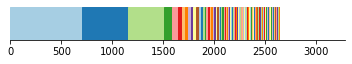

In [30]:
allel.plot_haplotype_frequencies(haps)

Lets reload the haplotype data as we will re-cluster this for the plot.

In [31]:
gene_bool = pos.locate_ranges([coeae1f_start], [coeae2f_end])
haps = allel.GenotypeArray(snps['call_genotype'].isel(variants=gene_bool).compute()).to_haplotypes()

And make the plot!!

In [32]:
#pal = np.array(palette[:])[[0,1,3,2,4], :]
#pal = np.array(palette)

In [33]:
palette

[(0.08667000000000002, 0.4621209803921563, 0.78003),
 (0.07385313725490195, 0.6646782352941176, 0.07385313725490195),
 (0.9, 0.7305882352941176, 0.09999999999999998),
 (0, 0, 0),
 (0.9, 0.9, 0.9)]

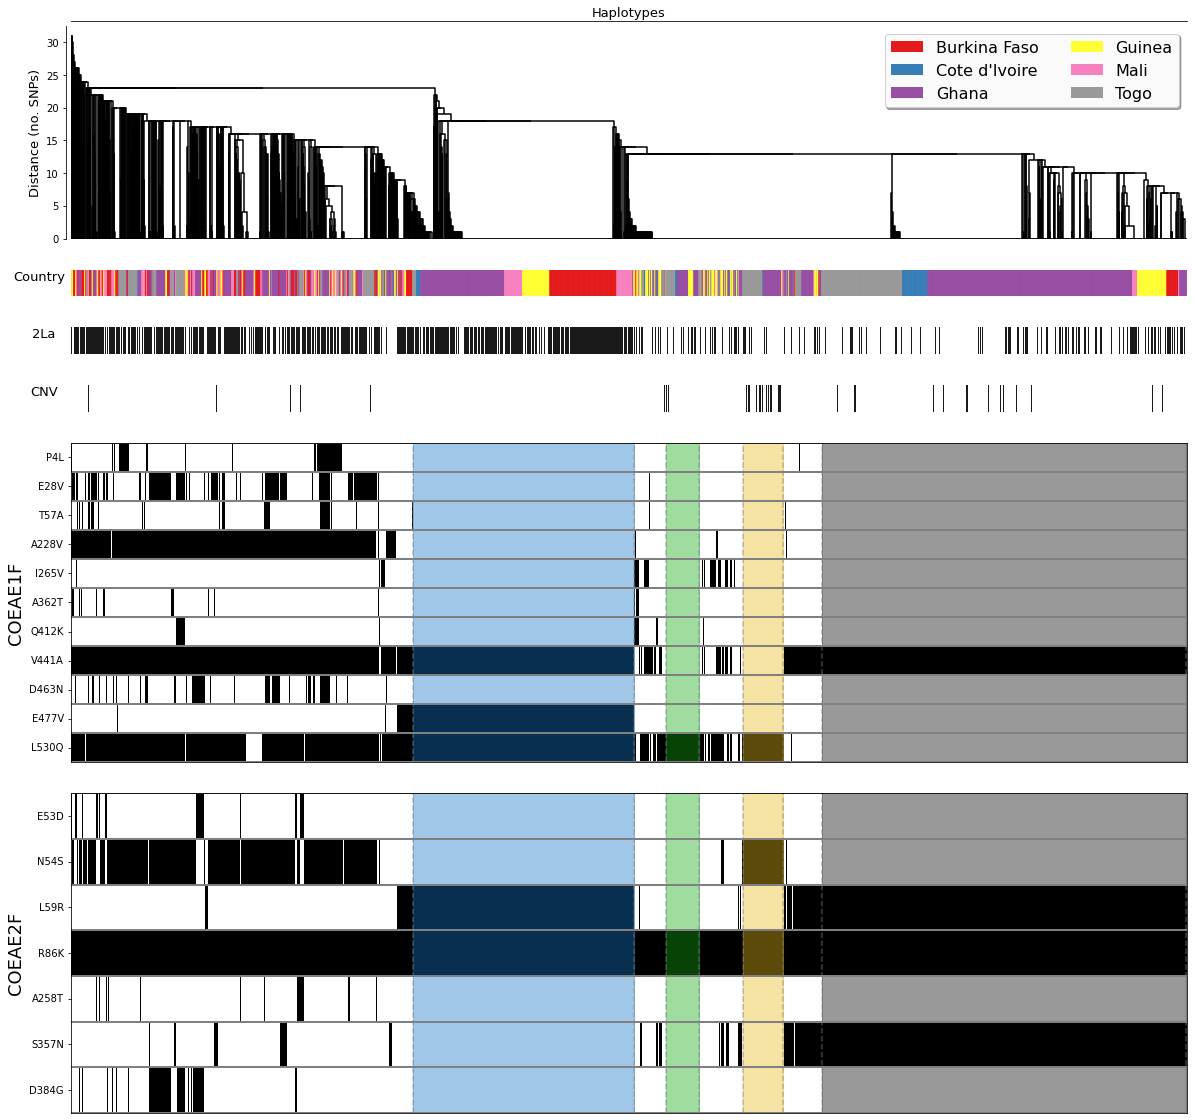

In [49]:
## Subplots and size ratios
fig, ax = plt.subplots(6,1, figsize=[20,20], gridspec_kw={'height_ratios': [8, 1, 1, 1, 12, 12]})

fig, ax_dend, ax_freq, cluster_spans, leaf2 = fig_haplotypes_clustered_dendro(haps, 
                                                          truncate_distance=0,
                                                          cut_height=1,
                                                          dpi=150, label_clusters=False, ax_dend=ax[0])

ax[0].set_ylabel("Distance (no. SNPs)", fontsize=13)
ax[0].set_xlabel("Haplotypes", fontsize=13)
ax[0].xaxis.tick_top()
ax[0].xaxis.set_label_position('top')
#ax[0].set_xticks(np.arange(0, len(pop_order), 200))

for i, pop in enumerate(pop_order[pop_column]):
    ax[1].axvline(x=i, color=pop_colours[pop])
sns.despine(ax=ax[1], left=True, bottom=True)
ax[1].set_xlim(0, len(pop_order))

for axes in ax[1:]:
    axes.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    
sns.heatmap(ax=ax[2], data=karyo.T, cmap='Greys', xticklabels="", cbar=None, alpha=0.9)
sns.heatmap(ax=ax[3], data=cnv.T, cmap='Greys', xticklabels="", cbar=None, alpha=0.9)
sns.heatmap(ax=ax[4], data=haps_df_227, cmap='Greys', cbar=None, xticklabels="")
sns.heatmap(ax=ax[5], data=haps_df_228, cmap='Greys', cbar=None, xticklabels="")

ax[1].tick_params(axis='y', which='both', left=False)
ax[2].tick_params(axis='y', which='both', left=False)
ax[3].tick_params(axis='y', which='both', left=False)
#ax[4].tick_params(axis='y', which='both', left=False)

ax[1].set_ylabel('Country', rotation = 0, fontsize=13, loc='center', labelpad=25)
ax[1].set_yticklabels("")
ax[2].set_ylabel('2La', rotation = 0, fontsize=13, loc='center', labelpad=20)
ax[2].set_yticklabels("")
ax[3].set_ylabel('CNV', rotation = 0, fontsize=13, loc='center', labelpad=20)
ax[3].set_yticklabels("")
ax[4].set_ylabel('COEAE1F', fontsize=18, loc='center')
ax[5].set_ylabel('COEAE2F', fontsize=18, loc='center')


for axes in ax[4], ax[5]:
    axes.set_yticks(axes.get_yticks())
    axes.set_yticklabels(axes.get_yticklabels(), rotation=0)
    for idx, span in enumerate(cluster_start_stop):
        start, stop = span
        axes.axvline(start, color='grey', linestyle="--", alpha=0.5)
        axes.axvline(stop, color='grey', linestyle="--", alpha=0.5)

        dend_patch_xy = (start, 0)
        axes.add_patch(plt.Rectangle(xy=dend_patch_xy,
                                           width=stop-start,
                                                height=40,
                                              color=palette[idx], alpha=0.4))

for i in range(haps_df_227.shape[0] + 1):
    ax[4].axhline(i, color='grey', lw=2)
for i in range(haps_df_227.shape[0] + 1):
    ax[5].axhline(i, color='grey', lw=2)
    
for axes in ax[4], ax[5]:
    for _, spine in axes.spines.items():
        spine.set_visible(True)
    
l = ax[0].legend(bars.values(), bars.keys(), loc='best', ncol=2, fancybox=True, shadow=True, framealpha=0.95, prop={'size':16})
l.draw_frame(True)

plt.savefig("../../figures/hapClusters.png", dpi=300)

### EHH in sweep clusters 

Designate flanks

In [50]:
loc_focus = 28548072
flanking = 5_000

upstream = pos.locate_ranges([loc_focus-flanking], [loc_focus])
downstream = pos.locate_ranges([loc_focus], [loc_focus+flanking])
pos_ehh_region = np.concatenate([pos[upstream], pos[downstream]])

upstream = pos.locate_ranges([coeae1f_start-2000], [loc_focus])
downstream = pos.locate_ranges([loc_focus], [coeae2f_end+2000])
pos_ehh_region = np.concatenate([pos[upstream], pos[downstream]])

### Calculate EHH in sweep cluster and WT

In [51]:
# get wt key 
keys = pd.Series(coho.keys())
wt_key = keys[keys.str.contains("wt")].to_list()[0]
wt_idxs = coho[wt_key]

# subset to down and upstream and calculate ehh decay in WT 
snps_up_wt = allel.GenotypeArray(snps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(wt_idxs, axis=1)
snps_down_wt = allel.GenotypeArray(snps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(wt_idxs, axis=1)
ehh_up_wt = allel.ehh_decay(snps_up_wt)
ehh_down_wt = allel.ehh_decay(snps_down_wt)
ehh_wt = np.concatenate([ehh_up_wt[::-1], ehh_down_wt])
ehh_wt_df = pd.DataFrame({'ehh': ehh_wt, 'group':wt_key, 'pos':pos_ehh_region})

# and then same in sweeps 
ehh_dict = {}
for sweep, idxs in coho.items():
    
    if 'wt' in sweep:
        continue
                    
    snps_up_sweep = allel.GenotypeArray(snps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(idxs, axis=1)
    snps_down_sweep = allel.GenotypeArray(snps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(idxs, axis=1)
    
    ehh_up_sweep = allel.ehh_decay(snps_up_sweep)
    ehh_down_sweep = allel.ehh_decay(snps_down_sweep)

    ehh_sweep = np.concatenate([ehh_up_sweep[::-1], ehh_down_sweep])
    ehh_dict[sweep] = pd.DataFrame({'ehh': ehh_sweep, 'group':sweep, 'pos':pos_ehh_region})


In [52]:
ehh_df = pd.concat([pd.concat(ehh_dict).reset_index(drop=True), ehh_wt_df], axis=0).reset_index(drop=True)

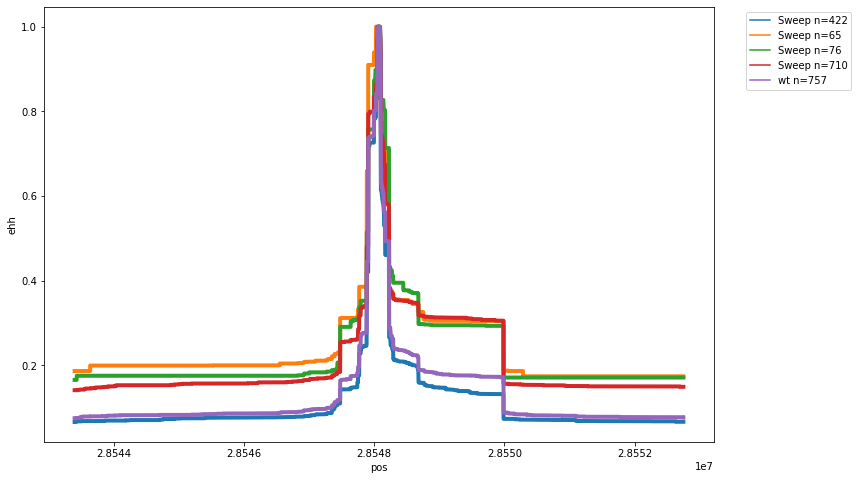

In [53]:
plt.figure(figsize=[12,8])
sns.lineplot(data=ehh_df, x='pos', y='ehh', hue='group', linewidth=4)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## With / without CNV in the CNV containing sweep

In [86]:
cnv_sweep_inds = coho['Sweep n=76']
wt_inds = coho['wt n=757']

metahaps, q = load_metahaps(cohorts, names, metaquery="aim_species == 'gambiae'")

meta_cnv_sweep = metahaps.take(cnv_sweep_inds)

In [89]:
meta_cnv_sweep['country'].value_counts()

Togo             37
Ghana            35
Mali              2
Guinea            1
Cote d'Ivoire     1
Name: country, dtype: int64

In [98]:
meta_cnv_bool = np.isin(meta_cnv_sweep['sample_id'], cnv_names)

meta_cnv = meta_cnv_sweep[meta_cnv_bool]
meta_non_cnv = meta_cnv_sweep[~meta_cnv_bool]

In [99]:
meta_non_cnv.shape

(5, 26)

In [104]:
meta_non_cnv

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,...,aim_species,country_iso,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin2_year,cohort_admin2_month
131,AZ0337-C,MA13-26,Austin Burt,Mali,Ouassorola,2014,8,12.9,-8.16,F,...,gambiae,MLI,Koulikouro,ML-2,Kati,gambiae,ML-2_gamb_2014,ML-2_gamb_2014_08,ML-2_Kati_gamb_2014,ML-2_Kati_gamb_2014_08
133,AZ0338-C,MA13-28,Austin Burt,Mali,Ouassorola,2014,8,12.9,-8.16,F,...,gambiae,MLI,Koulikouro,ML-2,Kati,gambiae,ML-2_gamb_2014,ML-2_gamb_2014_08,ML-2_Kati_gamb_2014,ML-2_Kati_gamb_2014_08
437,AV0006-C,KB016,Ken Vernick,Guinea,Koraboh,2012,10,9.28,-10.03,F,...,gambiae,GIN,Faranah,GN-F,Kissidougou,gambiae,GN-F_gamb_2012,GN-F_gamb_2012_10,GN-F_Kissidougou_gamb_2012,GN-F_Kissidougou_gamb_2012_10
1367,VBS19530-5563STDY7800608,WA-0596,Alexander Egyir-Yawson,Ghana,Obuasi,2017,9,6.2,-1.683,F,...,gambiae,GHA,Ashanti,GH-AH,Adansi North,gambiae,GH-AH_gamb_2017,GH-AH_gamb_2017_09,GH-AH_Adansi-North_gamb_2017,GH-AH_Adansi-North_gamb_2017_09
1598,VBS20387-5567STDY7801192,WA-0728,Edi Constant,Cote d'Ivoire,Aboisso,2017,9,5.467,-3.2,F,...,gambiae,CIV,Comoe,CI-CM,Sud-Comoe,gambiae,CI-CM_gamb_2017,CI-CM_gamb_2017_09,CI-CM_Sud-Comoe_gamb_2017,CI-CM_Sud-Comoe_gamb_2017_09


In [103]:
meta_cnv.location.value_counts()

Baguida    37
Obuasi     34
Name: location, dtype: int64

In [105]:
snps_up_cnv = allel.GenotypeArray(snps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(cnv_sweep_inds, axis=1).compress(meta_cnv_bool, axis=1)
snps_down_cnv = allel.GenotypeArray(snps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(cnv_sweep_inds, axis=1).compress(meta_cnv_bool, axis=1)
ehh_up_cnv = allel.ehh_decay(snps_up_cnv)
ehh_down_cnv = allel.ehh_decay(snps_down_cnv)
ehh_cnv = np.concatenate([ehh_up_cnv[::-1], ehh_down_cnv])
ehh_cnv = pd.DataFrame({'ehh': ehh_cnv, 'group':'sweep_cnv', 'pos':pos_ehh_region})

snps_up_non_cnv = allel.GenotypeArray(snps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(cnv_sweep_inds, axis=1).compress(~meta_cnv_bool, axis=1)
snps_down_non_cnv = allel.GenotypeArray(snps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(cnv_sweep_inds, axis=1).compress(~meta_cnv_bool, axis=1)
ehh_up_non_cnv = allel.ehh_decay(snps_up_non_cnv)
ehh_down_non_cnv = allel.ehh_decay(snps_down_non_cnv)
ehh_non_cnv = np.concatenate([ehh_up_non_cnv[::-1], ehh_down_non_cnv])
ehh_non_cnv = pd.DataFrame({'ehh': ehh_non_cnv, 'group':'sweep_non_cnv', 'pos':pos_ehh_region})


In [106]:
ehh_cnv_df = pd.concat([ehh_cnv, ehh_non_cnv, ehh_wt_df]).reset_index(drop=True)

<AxesSubplot:xlabel='pos', ylabel='ehh'>

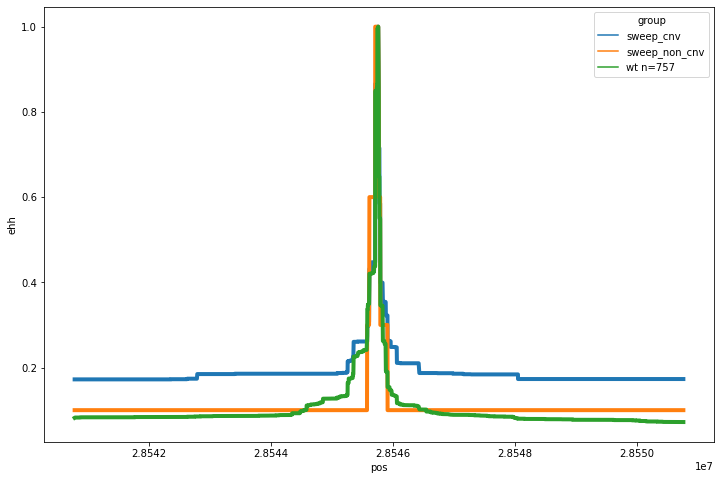

In [107]:
plt.figure(figsize=[12,8])
sns.lineplot(data=ehh_cnv_df, x='pos', y='ehh', hue='group', linewidth=4)

In [370]:
cnvs_ids = pd.read_csv("../../coe_cnv_sample_ids.tsv", sep="\t", index_col=0)

In [25]:
import warnings
warnings.filterwarnings('ignore')

karyotypes = pd.read_csv("/home/sanj/projects/gaard/results/gaard_karyotypes.tsv", sep="\t")
karyo_2la2 = pd.read_csv("/home/sanj/ag1000g/ag3_karyotypes.tsv", sep="\t", index_col=0).rename(columns={'partner_sample_id':'sample_id'})

karyo_2la = karyotypes.query("inversion == '2La'")

karyo_2la.loc[:, 'mean_genotype'] = karyo_2la.loc[:,'mean_genotype'].round(0)
karyo_2la2.loc[:, 'mean_genotype'] = karyo_2la2.loc[:,'mean_genotype'].round(0)

In [26]:
ag3_meta = meta[np.isin(meta['sample_id'], karyo_2la2['sample_id'])]
ag3_meta = ag3_meta.merge(karyo_2la2, on='sample_id')

gaard_meta = meta[np.isin(meta['partner_sample_id'], karyo_2la['partner_sample_id'])]
gaard_meta = gaard_meta.merge(karyo_2la, how='left', on='partner_sample_id')

meta2 = pd.concat([ag3_meta, gaard_meta], axis=0).query("aim_species == 'gambiae'")
metahaps = pd.DataFrame(np.repeat(meta2.values, 2, axis=0))
metahaps.columns = meta2.columns

In [48]:
meta = ag3.sample_metadata(cohorts)
metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
metahaps.columns = meta.columns

metahaps = metahaps.query("aim_species == 'gambiae'")

for k,v in coho.items():
    
    meta = metahaps.take(v)
    ids = meta['sample_id']
    a = meta['aim_species'].value_counts()
    meta['cnv_status'] = np.isin(meta['sample_id'], cnv_ids).astype(int)
    b = meta.location.value_counts()
    print("------------------------------------")
    print(k)
    print(a)
    print("\n")
    print(meta['cnv_status'].value_counts())
    print("\n")
    print(b)
    print("------------------------------------")
    print("\n")

------------------------------------
n=275 | E477V,E249D,A228V
gambiae    275
Name: aim_species, dtype: int64


0    273
1      2
Name: cnv_status, dtype: int64


Madina_North      126
Pala               34
Obuasi             31
Kababougou         26
Bana Village       13
Aboisso            10
Souroukoudinga      9
Koraboh             7
Koundara            6
Baguida             6
Ouassorola          3
Kela                2
Koforidua           1
Madina_West         1
Name: location, dtype: int64
------------------------------------


------------------------------------
n=62 | N512K,V441G,L304V,E276D,E249D,A228V,H199Q
gambiae    62
Name: aim_species, dtype: int64


0    57
1     5
Name: cnv_status, dtype: int64


Baguida         21
Obuasi          17
Madina_West      8
Aboisso          4
Koforidua        3
Madina_North     3
Koraboh          3
Koundara         2
Kababougou       1
Name: location, dtype: int64
------------------------------------


------------------------------------
n=

In [122]:
meta = metahaps.iloc[coho['n=73 | N512K,D496E,V441G,L304V,E276D,E249D,A228V,K163N,E28V']]
meta.location.value_counts()

Baguida    37
Obuasi     35
Aboisso     1
Name: location, dtype: int64

In [ ]:
snpdf, coho = phase3cluster(cohorts, "AGAP006227-RA", contig, cut=2, t=0, min_cohort_size=40)

### Get freqs of multiallelic SNPs too.

In [37]:
meta = ag3.sample_metadata(cohorts)
metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
metahaps.columns = meta.columns

metah = metahaps.take(coho['n=465 | E477V'])

In [85]:
metah['sample_id'].value_counts() > 

AV0149-C                    2
AB0375-C                    2
AB0526-C                    2
VBS19204-5563STDY7800290    2
AB0523-C                    2
                           ..
AV0029-Cx                   1
AV0045-C                    1
AV0033-C                    1
AV0039-C                    1
VBS20190-5568STDY7801449    1
Name: sample_id, Length: 390, dtype: int64

In [96]:
sweep_homs = metah.sample_id.value_counts().loc[lambda x: x>1].to_frame().reset_index()

In [97]:
sweep_homs

,index,sample_id
0,AV0149-C,2
1,AB0375-C,2
2,AB0526-C,2
3,VBS19204-5563STDY7800290,2
4,AB0523-C,2
...,...,...
70,VBS19471-5563STDY7800558,2
71,VBS19466-5563STDY7800553,2
72,AZ0331-C,2
73,AZ0321-C,2


['AG1000G-GH',
 'AG1000G-ML-A',
 'AG1000G-BF-A',
 'AG1000G-BF-B',
 'AG1000G-GN-A',
 'AG1000G-GN-B',
 '1244-VO-GH-YAWSON-VMF00051',
 '1245-VO-CI-CONSTANT-VMF00054',
 '1253-VO-TG-DJOGBENOU-VMF00052',
 '1237-VO-BJ-DJOGBENOU-VMF00050']

In [102]:
np.where(np.isin( meta['sample_id'], sweep_homs['index']))

(array([ 115,  118,  122,  123,  125,  132,  133,  138,  139,  177,  195,
         213,  218,  223,  229,  235,  237,  297,  299,  320,  330,  333,
         334,  336,  377,  379,  380,  381,  397,  401,  403,  411,  420,
         428,  431,  433,  434,  435,  440,  441,  471,  496,  509,  523,
         526,  533,  537,  602,  616,  633,  641,  650,  653,  654,  656,
         665,  666,  694,  721,  722,  769,  773,  774,  783,  788,  796,
         893,  907,  924,  932,  935,  946,  948, 1347, 1369]),)

In [118]:
newcoho['n=465 | E477V']

(array([ 115,  118,  122,  123,  125,  132,  133,  138,  139,  177,  195,
         213,  218,  223,  229,  235,  237,  297,  299,  320,  330,  333,
         334,  336,  377,  379,  380,  381,  397,  401,  403,  411,  420,
         428,  431,  433,  434,  435,  440,  441,  471,  496,  509,  523,
         526,  533,  537,  602,  616,  633,  641,  650,  653,  654,  656,
         665,  666,  694,  721,  722,  769,  773,  774,  783,  788,  796,
         893,  907,  924,  932,  935,  946,  948, 1347, 1369]),)

In [119]:
newcoho = {}
for k,idxs in coho.items():
    
    meta = ag3.sample_metadata(cohorts)
    metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
    metahaps.columns = meta.columns
    
    metah  = metahaps.take(idxs)
    sweep_homs = metah.sample_id.value_counts().loc[lambda x: x>1].reset_index()
    
    newcoho[k] = np.where(np.isin(meta['sample_id'], sweep_homs['index']))[0]

geno = allel.GenotypeArray(ag3.snp_genotypes(transcript, cohorts))
pos = allel.SortedIndex(ag3.snp_sites(field='POS', region=transcript))
    
df_snps = get_afs_from_cohort(newcoho, geno, pos, transcript, 10)

In [123]:
df_snps.query("max_af > 0.05 & effect == 'NON_SYNONYMOUS_CODING'")

,contig,position,ref_allele,alt_allele,pass_gamb_colu_arab,pass_gamb_colu,pass_arab,transcript,effect,impact,...,alt_codon,aa_pos,ref_aa,alt_aa,aa_change,n=465 | E477V,n=741 |,n=373 |,wt n=1536,max_af
637,2L,28545608,A,T,True,True,True,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,cAg,530.0,L,Q,L530Q,0.813333,0.488764,0.664062,0.779481,0.813333
1113,2L,28545767,T,A,True,True,True,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,gTg,477.0,E,V,E477V,0.473333,0.117978,0.000000,0.102594,0.473333
1400,2L,28545862,A,G,True,True,True,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,Cac,469.0,Y,H,Y469H,0.746667,0.289326,0.117188,0.544811,0.746667
1453,2L,28545880,C,T,True,True,True,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,Aat,463.0,D,N,D463N,0.093333,0.036517,0.015625,0.099057,0.099057
1649,2L,28545945,A,G,False,True,False,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,gCg,441.0,V,A,V441A,0.966667,0.828652,0.250000,0.780142,0.966667
1901,2L,28546029,T,G,False,False,True,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,aCg,413.0,K,T,K413T,0.966667,0.851124,0.296875,0.800708,0.966667
2369,2L,28546185,T,G,True,True,True,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,gaC,386.0,E,D,E386D,0.706667,0.266854,0.125000,0.530660,0.706667
2452,2L,28546213,C,T,True,True,True,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,gAa,377.0,G,E,G377E,0.980000,0.971910,0.796875,0.904481,0.980000
2567,2L,28546251,C,G,False,False,True,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,caC,364.0,Q,H,Q364H,0.466667,0.120787,0.000000,0.106132,0.466667
2819,2L,28546335,G,T,False,False,False,AGAP006227-RA,NON_SYNONYMOUS_CODING,MODERATE,...,agA,336.0,S,R,S336R,0.653333,0.289326,0.140625,0.492925,0.653333


In [79]:
aa_freqs = df_effects.merge(aa_freqs.reset_index())

### Distance between sweeps

In [357]:
sample_set = cohorts[3]
metaquery = None
cut=2
t=0
min_cohort_size=4

genepos = ag3.snp_sites(region=gene, field='POS').compute()
genehaps = haps.compress(pos.locate_intersection(genepos)[0], axis=0)

dists = []
xs,ys = [], []

for x, y in itertools.combinations(coh.keys(),2):
    
    haps2 = allel.HaplotypeArray(genehaps.take([coh[x][0], coh[y][0]], axis=1))
    dist = scipy.spatial.distance.pdist(haps2.T, metric='hamming')
    dists.append(dist * haps2.shape[0])
    xs.append(x)
    ys.append(y)
    

df = pd.DataFrame({0:xs, 1:ys, 'dist':dists})
df.head(4)

## Cluster larger region

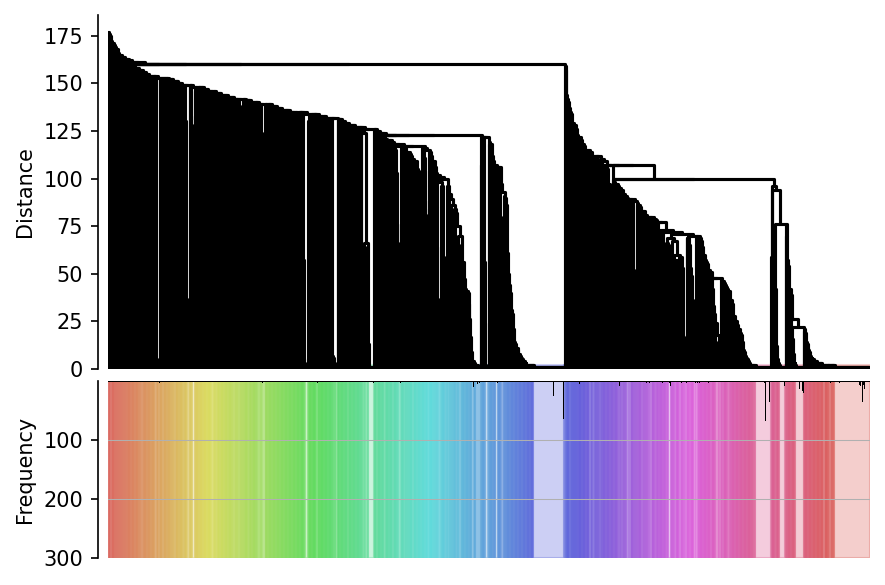

In [61]:
snps = ag3.haplotypes(contig, sample_sets=cohorts, analysis='gamb_colu')
names = snps['sample_id'].values
pos = allel.SortedIndex(snps['variant_position'])
gene_bool = pos.locate_ranges([28_535_396], [28_567_938])

haps = allel.GenotypeArray(snps['call_genotype'].isel(variants=gene_bool).compute()).to_haplotypes()
fig, ax_dend, ax_freq, cluster_spans, leaf2 = fig_haplotypes_clustered(haps, 
                                                          truncate_distance=0,
                                                          cut_height=2,
                                                          dpi=150, label_clusters=False)

In [62]:
cluster_spans = np.array(cluster_spans, dtype='object')

In [63]:
lens = np.array([len(c[2]) for c in cluster_spans])

In [64]:
sweep_clusters = cluster_spans[lens > 40]

In [104]:
meta = ag3.sample_metadata(cohorts)
meta = meta.query("sample_id in @names")
meta['sample_id'] = pd.Categorical(meta['sample_id'], categories = names, ordered = True)
meta = meta.sort_values(by='sample_id')
metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
metahaps.columns = meta.columns

assert metahaps.shape[0] == haps.shape[1], "Wrong shape Dude!!"

In [105]:
[len(c[2]) for c in sweep_clusters]

[419, 296, 54, 86, 596]

In [107]:
for span1, span2, idxs in sweep_clusters:
    
    m = metahaps.take(idxs)
    print(len(idxs))
    print(m['aim_species'].value_counts())
    

419
gambiae                          417
coluzzii                           1
intermediate_gambiae_coluzzii      1
Name: aim_species, dtype: int64
296
coluzzii                         243
gambiae                           50
intermediate_gambiae_coluzzii      3
Name: aim_species, dtype: int64
54
gambiae    54
Name: aim_species, dtype: int64
86
gambiae    86
Name: aim_species, dtype: int64
596
gambiae                          594
coluzzii                           1
intermediate_gambiae_coluzzii      1
Name: aim_species, dtype: int64
